# Case 3 - drug reviews (text analysis)
Neural networks for Health Technology Applications <br>
14.2.2021 Marja Satukangas <br>
Metropolia University of Applied Sciences

## 1. Introduction

The aim of this notebook is to create a model that can predict the rating of a drug based on the review and find the answer to the question of is that is even possible. Rating is aimed to be predicted to be "negative", "neutral" or "positive". For creating the model text processing methods are used to handle the written reviews.

An article http://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf has been used as a reference for the experiment and at the end the results are compared to the results of the experiment introduced in the article.


In [122]:
# Importing basic libraries
import time # for timing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Dense, Activation # layers for neural networks
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, Dense, SimpleRNN
from tensorflow.keras import models, layers
import os


MAX_LEN = 200 #number of most common words in samples found from the dictionary
NUM_WORDS = 10000 #number of most common words of the dataset

display(tf.__version__)

'2.4.1'

## 2. Dataset

The dataset used for creating the model is downloaded from https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018. This dataset is extracted from https://www.drugs.com/.


The dataset cosists of two folders: testset and trainset. Both folders have same features:
- uniqueID
- drugName
- condition
- review
- rating
- date
- usefulCount

In train set there is 161297 samples and in test set 53766 samples. The splitting ratio is thus 0.75/0.25 which was good for the experiment. Both sets have missing "condition"-values. Those are left to be missing, because in this experiment only ratings and reviews are used.

In [123]:
data_folder = '../input/kuc-hackathon-winter-2018/'
print(os.listdir(data_folder))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [124]:
# Create dataframes train and test
train = pd.read_csv(data_folder + 'drugsComTrain_raw.csv')
test = pd.read_csv(data_folder + 'drugsComTest_raw.csv')

# Show the first 5 rows of the train set
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [125]:
train.count()

uniqueID       161297
drugName       161297
condition      160398
review         161297
rating         161297
date           161297
usefulCount    161297
dtype: int64

In [126]:
test.count()

uniqueID       53766
drugName       53766
condition      53471
review         53766
rating         53766
date           53766
usefulCount    53766
dtype: int64

Below the distribution of ratings are shown. From the histogram we can see that there are a lot of positive ratings and negative ratings but neutral ratings are less represented. In test set and train set the distribution is similar.

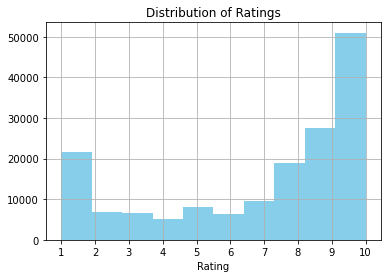

In [127]:
train.rating.hist(color = 'skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks([i for i in range(1,11)]);

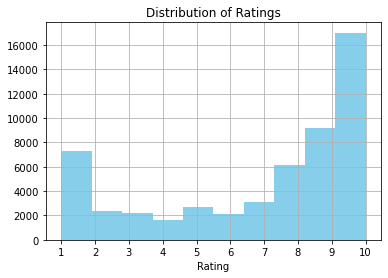

In [128]:
test.rating.hist(color = 'skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks([i for i in range(1,11)]);

## 3. Text preprocessing

### Text to numbers

Before the model can be created, the text in the reviews need to be turned into a numerical form by tokenizing. [Keras Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) turns text samples into lists of integers, that represent indexes of tokens in a dictionary and by default converts the words into lowercase and filters out special characters. A parameter "num_words" can be given to the tokenizer to restrict the maximum number of words in the dictionary when only the most frequently occuring words are kept. The parameter is defined in the beginning of the notebook together with the library imports.

In [129]:
# Tokenize the text
samples = train['review']
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(samples)


Training set has 51429 different words from which the most common words are included to the dictionary (defined be parameter "num_words")

In [130]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.


Then the samples are turned into sequences using the dictionary created before and samples are padded to have the same length. Parameter "maxlen" defines the length of the sequences. If a sample has less tokens than defined in "maxlen", the indexes are replaced by zeros.

In [131]:
sequences = tokenizer.texts_to_sequences(samples)
data = pad_sequences (sequences, maxlen = MAX_LEN)

data[20]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3060,
         12, 1981,    1,   10, 1847,   21,    2,  338,   21, 4377,    2,
        351, 1874, 3362,   21, 2148, 1602,   12,  114,  624,  114, 1686,
       1688,  103, 1312,   24,  297,   15,    3, 7909,    1,  156,  105,
        493,    1,   10,   36,    2,   21,    9,   

In [132]:
#tokenizing the test set
test_samples = test['review']

test_sequences = tokenizer.texts_to_sequences(test_samples)
test_data = pad_sequences (test_sequences, maxlen = MAX_LEN)

### Simplifying rating categories

To make categorizing reviews more simple, the ratings are divided into three different categories as done in the article mentioned above: 
0: “negative” (rating < 5),
1: “neutral” (rating 5 or 6),
2: “positive” (rating > 6).

In [133]:
# Create 3 categories

ratings = train['rating'].values
labels = 1.0*(ratings >= 8) + 1.0*(ratings >= 5)

test_ratings = test['rating'].values
test_labels = 1.0*(test_ratings >= 8) + 1.0*(test_ratings >= 5)

### Split into training and validation datasets

Next we take validation set out of training set so that 75% of train set remains as train set and rest 25% goes to the validation set.

In [134]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size = 0.250, random_state = 2021)

### Distribution of categories

To see the distribution of categories, histograms of the distributions are drawn for all datasets. From the histograms we can see again that most of the ratings are postive and there is only a little amount of negative or neutral ratings. Distributions are similar in all the datasets.

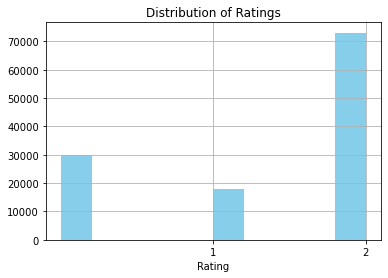

In [135]:
df_train = pd.DataFrame(train_labels)
df_train.hist(color = 'skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks([i for i in range(1,3)]);

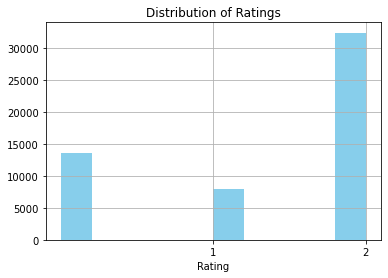

In [136]:
df_train = pd.DataFrame(test_labels)
df_train.hist(color = 'skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks([i for i in range(1,3)]);

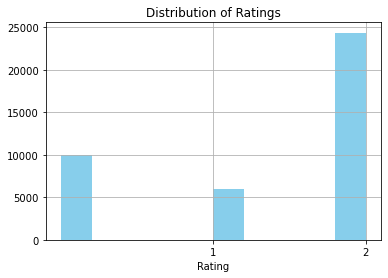

In [137]:
df_val = pd.DataFrame(val_labels)
df_val.hist(color = 'skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks([i for i in range(1,3)]);

### One-hot-code labels

To enable the model handle labels, the categories are encoded to binary values so that they form a 3 dimensional vectors in which 1 represents the label.

In [138]:
# Convert outputs to one-hot-coded categoricals
from tensorflow.keras.utils import to_categorical

train_cat = to_categorical(train_labels)
val_cat = to_categorical(val_labels)
test_cat = to_categorical(test_labels)

train_cat

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### Word embedding

The sample features can be one-hot encoded before they are given as inputs to the model, but because of the computer costlyness of this method, word embedding is used. In embedding process words are turned into vectors of floating point values. Values of vectors are trainable and change during the training process. The word vectors are situated near each other in the embedding space, if the corresponding words share some semantic meaning and thus also relationships of the words can be experimented. Word vectors can be even 1024 dimensional for large datasets and for small datasets for example 8 dimensional vectors could work.

Word embeddins can be added as a layer to the model as done in this experiment. I used 16 dimensional vectors for embeddings.

In [139]:
embedding_layer = Embedding(NUM_WORDS, 32, input_length = MAX_LEN)

## 4. Modelling

To find an optimal model, different models were experimented with: Conv1D-model, RNN(recurrent neural networks)-model and LSTM(long short term memory)-model. I also changed batch sizes and optimizers to find the best solution. First I experimented the models with smaller set of data and after that with a larger set. Adam-optimizer seemed to work good so I decided to use it with all the models. Training the models was very time cunsuming so it was not possible to experiment with that many different parameters. Especially LSTM model was computer costly.

In [140]:
# Plot the accuracy and loss
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Conv1D model
Convolutional model has two convolutional layers and pooling layers as hidden layers. The input layer is embedding layer and output layer a dense layer with three neurons that represent the three categories. Validation accuracy is in the end of training 0.81 but loss is 1.04. The plot shows that loss increases with every epochs. This is a signal of model not working. 

In [144]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(layers.Conv1D(32, 3, padding="valid", activation="relu"))
model1.add(layers.MaxPooling1D(5))
model1.add(layers.Conv1D(32, 3, padding="valid", activation="relu"))
model1.add(layers.GlobalMaxPooling1D())
model1.add(layers.Dense(3, activation = 'softmax'))

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

model1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 198, 32)           3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 37, 32)            3104      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total params: 326,307
Trainable params: 326,307
Non-trainable params: 0
_______________________________________________

In [145]:
%%time
history1 = model1.fit(train_data, train_cat, 
                    epochs = 10, 
                    batch_size = 128,
                    verbose = 1,
                    validation_data = (val_data, val_cat))

Epoch 1/10
946/946 [==============================] - 28s 29ms/step - loss: 0.6920 - acc: 0.7124 - val_loss: 0.5885 - val_acc: 0.7682
Epoch 2/10
946/946 [==============================] - 27s 29ms/step - loss: 0.4393 - acc: 0.8301 - val_loss: 0.5958 - val_acc: 0.7735
Epoch 3/10
946/946 [==============================] - 27s 29ms/step - loss: 0.3625 - acc: 0.8647 - val_loss: 0.5955 - val_acc: 0.7865
Epoch 4/10
946/946 [==============================] - 27s 29ms/step - loss: 0.2993 - acc: 0.8928 - val_loss: 0.6189 - val_acc: 0.7916
Epoch 5/10
946/946 [==============================] - 27s 29ms/step - loss: 0.2495 - acc: 0.9137 - val_loss: 0.6605 - val_acc: 0.7945
Epoch 6/10
946/946 [==============================] - 27s 29ms/step - loss: 0.2041 - acc: 0.9316 - val_loss: 0.7188 - val_acc: 0.8061
Epoch 7/10
946/946 [==============================] - 27s 29ms/step - loss: 0.1677 - acc: 0.9460 - val_loss: 0.7762 - val_acc: 0.8092
Epoch 8/10
946/946 [==============================] - 27s 28ms

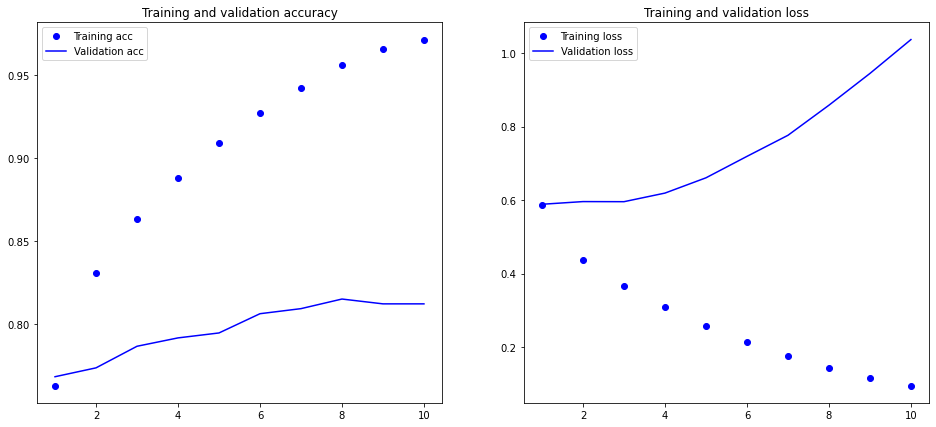

In [146]:
plot_history(history1)

### RNN-model

Simple RNN model achieved 0.65 loss and 0.75 accuracy with validation set. 

In [149]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(SimpleRNN(32))
model2.add(layers.Dense(3, activation = 'softmax'))

model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 99        
Total params: 322,179
Trainable params: 322,179
Non-trainable params: 0
_________________________________________________________________


In [150]:
%%time
history2 = model2.fit(train_data, train_cat, 
                    epochs = 10, 
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (val_data, val_cat))

Epoch 1/10
3781/3781 [==============================] - 244s 64ms/step - loss: 0.7708 - acc: 0.6849 - val_loss: 0.6666 - val_acc: 0.7396
Epoch 2/10
3781/3781 [==============================] - 244s 65ms/step - loss: 0.6326 - acc: 0.7493 - val_loss: 0.6497 - val_acc: 0.7420
Epoch 3/10
3781/3781 [==============================] - 243s 64ms/step - loss: 0.6215 - acc: 0.7506 - val_loss: 0.8223 - val_acc: 0.6530
Epoch 4/10
3781/3781 [==============================] - 241s 64ms/step - loss: 0.7178 - acc: 0.7069 - val_loss: 0.8468 - val_acc: 0.6254
Epoch 5/10
3781/3781 [==============================] - 243s 64ms/step - loss: 0.7918 - acc: 0.6596 - val_loss: 0.7492 - val_acc: 0.7047
Epoch 6/10
3781/3781 [==============================] - 238s 63ms/step - loss: 0.7093 - acc: 0.7092 - val_loss: 0.7730 - val_acc: 0.6899
Epoch 7/10
3781/3781 [==============================] - 239s 63ms/step - loss: 0.7119 - acc: 0.7145 - val_loss: 0.7323 - val_acc: 0.7159
Epoch 8/10
3781/3781 [===================

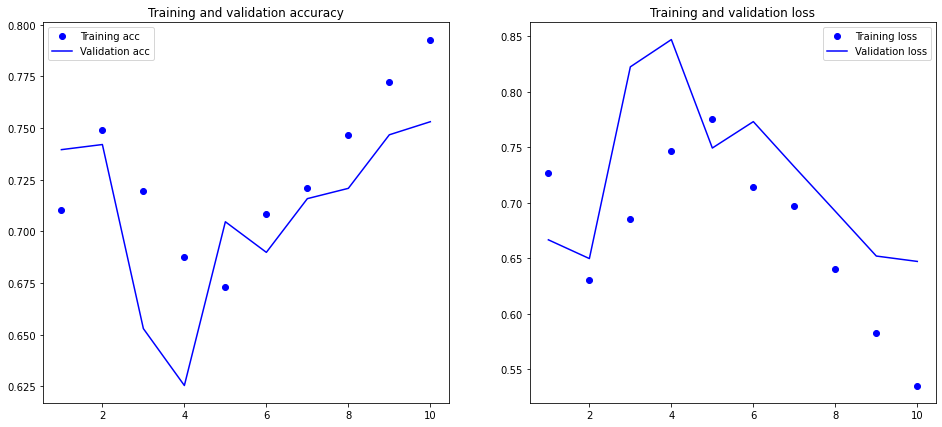

In [151]:
plot_history(history2)

### Stacked LSTM-model

LSTM model has a more complex recurrent network structure than RNN and is many times more efficient than RNN. I wanted to find out how it works for the task and created a stacked LSTM model. That achieved validation accuracy of 0.80 and loss of 0.59 with 8 epochs.

In [158]:
model3 = models.Sequential()
model3.add(embedding_layer)
model3.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1,return_sequences=True))
model3.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1))
model3.add(layers.Dense(3, activation = 'softmax'))
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model3.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_28 (LSTM)               (None, 200, 32)           8320      
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 99        
Total params: 336,739
Trainable params: 336,739
Non-trainable params: 0
_________________________________________________________________


In [160]:
%%time
history3 = model3.fit(train_data, train_cat, 
                    epochs = 8, 
                    batch_size = 128,
                    verbose = 1,
                    validation_data = (val_data, val_cat))

Epoch 1/8
946/946 [==============================] - 557s 589ms/step - loss: 0.5105 - acc: 0.7990 - val_loss: 0.5747 - val_acc: 0.7772
Epoch 2/8
946/946 [==============================] - 576s 609ms/step - loss: 0.4202 - acc: 0.8378 - val_loss: 0.5936 - val_acc: 0.7888
Epoch 3/8
946/946 [==============================] - 578s 611ms/step - loss: 0.3828 - acc: 0.8546 - val_loss: 0.5683 - val_acc: 0.7959
Epoch 4/8
946/946 [==============================] - 565s 598ms/step - loss: 0.3577 - acc: 0.8654 - val_loss: 0.5674 - val_acc: 0.7953
Epoch 5/8
946/946 [==============================] - 560s 592ms/step - loss: 0.3373 - acc: 0.8740 - val_loss: 0.5617 - val_acc: 0.7996
Epoch 6/8
946/946 [==============================] - 560s 592ms/step - loss: 0.3192 - acc: 0.8821 - val_loss: 0.5827 - val_acc: 0.8039
Epoch 7/8
946/946 [==============================] - 573s 606ms/step - loss: 0.3011 - acc: 0.8895 - val_loss: 0.5968 - val_acc: 0.7978
Epoch 8/8
946/946 [==============================] - 57

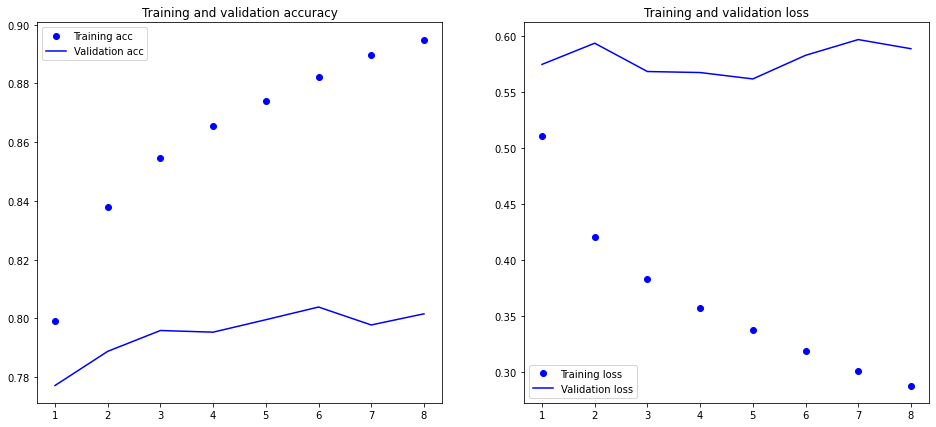

In [161]:
plot_history(history3)

## 5. Results

Any of the models didn't work very well based on validation accuracy and loss. Based on these I chose to use LSTM model and see how it works with test set. 

### Testing LSTM-model

Below different metrics are calculated. From the calculations we can see that model works better for negative and positive reviews. Neutral reviews are not classified that well. This may be caused by the size of data.<br>

Accuracy for the test set is 0.80, which is quite good. Cohens kappa with linear weights is 0.65 and with quadratic weights 0.77. Cohen's kappa is a statistic that is used to measure inter-rater reliability for qualitative items. 1 represents the best value and higher than 0.75 is considered to be excellent so in this case we can be satisfied to the score.

In [171]:
# Find the predicted values for the validation set
pred_labels = np.argmax(model3.predict(test_data), axis = 1)

# Calculate the classification report
cr = classification_report(test_labels, pred_labels)
print(cr)

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     13497
         1.0       0.49      0.49      0.49      7920
         2.0       0.88      0.89      0.89     32349

    accuracy                           0.80     53766
   macro avg       0.72      0.72      0.72     53766
weighted avg       0.80      0.80      0.80     53766



In [172]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred_labels3).T
print(cm)

[[10611  1505  1233]
 [ 1660  3887  2394]
 [ 1226  2528 28722]]


In [173]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(test_labels, pred_labels3)
print(f"Cohen's kappa (linear)    = {k:.4f}")
k2 = cohen_kappa_score(test_labels, pred_labels3, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.4f}")

Cohen's kappa (linear)    = 0.6450
Cohen's kappa (quadratic) = 0.7710


## 6. Conclusions

In the original article an overall accuracy of 0.75 and 0.43 cohen's kappa was achieved with in-domain sentiment analysis. Compared to this my model scored well. As a conclusion the model can predict well reviews that are positive but negative and neutral reviews can not be predicted that reliably. Maybe larger dataset that has more neutral and negative reviews could help. Also more complicated LSTM-model could increase the performance of the model.